In this notebook, I am reproducting the result in the paper of "DoH Insight: Detecting DNS over HTTPS by Machine Learning", and trying to dig further if any robust features against any attacks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()
sns.set_style("darkgrid")

the paper is "DoH Insight: Detecting DNS over HTTPS by Machine Learning" <https://sappan-project.eu/wp-content/uploads/2020/09/DOH-2.pdf>. It brings in a nice dataset as well as a list of good features. The source of dataset is at <https://figshare.com/articles/dataset/Dataset_used_for_detecting_DNS_over_HTTPS_by_Machine_Learning_/12277448> or one can go <https://zenodo.org/record/3906526> for the full dataset.


In [2]:
df_train = pd.read_csv('./doh-dataset.csv', delimiter=';')
df_train.head()

,is_doh,datasrc,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,...,mindelay,avgdelay,maxdelay,time_leap_ration,bursts,fazzel,autocorr,stSum,ndSum,rdSum
0,0,chrome,2876,4,4134,3,1.437413,1.333333,80.0,1378.0,...,30.0,50.666667,80.0,1.000000,3.0,3.0,-316,0,1,0
1,0,chrome,1036,8,3559,7,3.435328,1.142857,148.0,508.4,...,2.0,78.142857,148.0,0.833333,5.0,6.0,225,1,2,0
2,0,chrome,3170,11,7742,10,2.442271,1.100000,174.0,774.2,...,32.0,91.800000,174.0,0.857143,6.0,7.0,239,-1,0,0
3,1,chrome,1413,10,3561,12,2.520170,0.833333,52.0,296.8,...,2.0,34.952381,52.0,1.142857,8.0,7.0,149,-1,2,-3
4,0,chrome,913,8,6158,8,6.744797,1.000000,64.0,769.8,...,2.0,36.533333,64.0,0.833333,5.0,6.0,543,1,-2,1


In [3]:
df_train.columns

Index(['is_doh', 'datasrc', 'bytes_out', 'num_pkts_out', 'bytes_in',
       'num_pkts_in', 'bytes_ration', 'num_pkts_ration', 'time',
       'av_pkt_size_in', 'av_pkt_size_out', 'var_pkt_size_in',
       'var_pkt_size_out', 'median_in', 'median_out', 'mindelay', 'avgdelay',
       'maxdelay', 'time_leap_ration', 'bursts', 'fazzel', 'autocorr', 'stSum',
       'ndSum', 'rdSum'],
      dtype='object')

In [4]:
# the training sample distribution is skewed, 
# so RepeatedStratifiedKFold is suggested for cross validation
df_train['is_doh'].value_counts()

0    452626
1     34195
Name: is_doh, dtype: int64

In [5]:
# as the paper has mentioned, DoH queries have long duration
df_train_wide=df_train.pivot(columns='is_doh', values='time')

<AxesSubplot:ylabel='Frequency'>

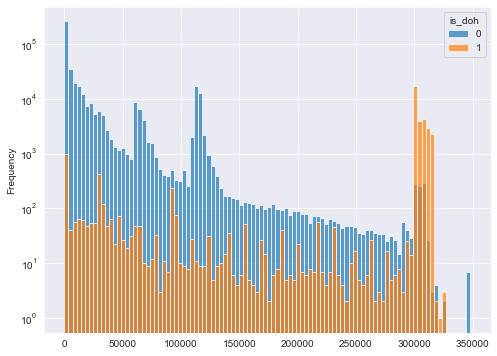

In [6]:
df_train_wide.plot.hist(bins=100, figsize=(8,6), alpha=0.7, log=True)

In [7]:
# 
df_train_client=df_train.pivot(columns='datasrc', values='time')

<AxesSubplot:ylabel='Frequency'>

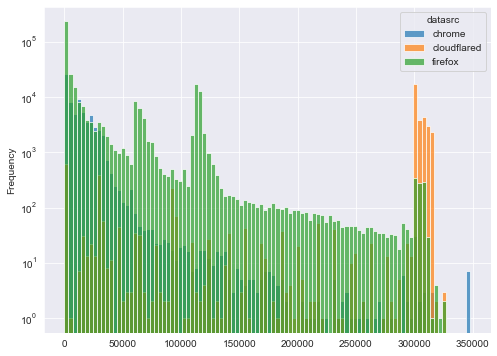

In [8]:
df_train_client.plot.hist(bins=100, figsize=(8,6), alpha=0.7, log=True)

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [10]:
train = df_train.drop('datasrc', axis=1)
features = list(train.columns[1:])
print(features)

['bytes_out', 'num_pkts_out', 'bytes_in', 'num_pkts_in', 'bytes_ration', 'num_pkts_ration', 'time', 'av_pkt_size_in', 'av_pkt_size_out', 'var_pkt_size_in', 'var_pkt_size_out', 'median_in', 'median_out', 'mindelay', 'avgdelay', 'maxdelay', 'time_leap_ration', 'bursts', 'fazzel', 'autocorr', 'stSum', 'ndSum', 'rdSum']


Let's try our favorite `xgboost` and `GridSearch` for an optimal parameter set. I reused my old Kaggle script <https://www.kaggle.com/phunter/xgboost-with-gridsearchcv>. A better choice of parameter search can be `AutoGluon` <https://auto.gluon.ai/stable/index.html>

In [11]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[1],
              'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [5,6],
              'min_child_weight': [11],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5,10],
              'missing':[-999],
              'seed': [1337]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
clf = GridSearchCV(xgb_model, parameters, n_jobs=4, 
                   cv=cv, 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], train["is_doh"])


print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Fitting 30 folds for each of 4 candidates, totalling 120 fits


/Users/hliu/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:45] WARNING: /private/var/folders/gt/gmcvnkcj6fb36gwkn_zcd9200000gn/T/pip-install-ghmm0hix/xgboost_9fe39133e32348ad9f2da26a664a5e0a/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 10, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 1337, 'subsample': 0.8}
Grid scores on development set:
0.996 (+/-0.002) for {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 1337, 'subsample': 0.8}
0.997 (+/-0.001) for {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5,

The feature importance bar chart can confirm the paper's conclusion where `duration` and `delay` features are the most important ones, however, such features can be obfuscated and masked with other HTTPS traffic

<AxesSubplot:>

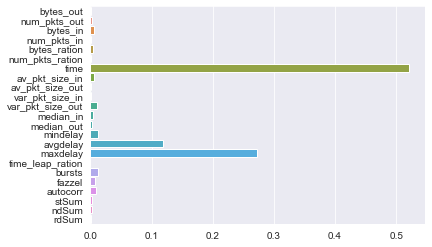

In [12]:
sns.barplot(x=clf.best_estimator_.feature_importances_,y=features)

Now the question becomes that, can we bring a stronger classifier and leverage some robust features? Let's drop these top features:

In [13]:
train_drop = df_train.drop(['datasrc','time','maxdelay','avgdelay','mindelay','bursts','fazzel'], axis=1)
features_drop = list(train_drop.columns[1:])
print(features_drop)

['bytes_out', 'num_pkts_out', 'bytes_in', 'num_pkts_in', 'bytes_ration', 'num_pkts_ration', 'av_pkt_size_in', 'av_pkt_size_out', 'var_pkt_size_in', 'var_pkt_size_out', 'median_in', 'median_out', 'time_leap_ration', 'autocorr', 'stSum', 'ndSum', 'rdSum']


In [14]:
xgb_model_drop = xgb.XGBClassifier()
parameters = {'nthread':[1],
              'objective':['binary:logistic'],
              'learning_rate': [0.05], 
              'max_depth': [5,6],
              'min_child_weight': [11],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5,10],
              'missing':[-999],
              'seed': [1337]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
clf = GridSearchCV(xgb_model_drop, parameters, n_jobs=4, 
                   cv=cv, 
                   scoring='roc_auc',
                   verbose=0, refit=True)

clf.fit(train_drop[features_drop], train_drop["is_doh"])

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

/Users/hliu/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:33] WARNING: /private/var/folders/gt/gmcvnkcj6fb36gwkn_zcd9200000gn/T/pip-install-ghmm0hix/xgboost_9fe39133e32348ad9f2da26a664a5e0a/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 10, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 1337, 'subsample': 0.8}
Grid scores on development set:
0.999 (+/-0.001) for {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 1, 'objective': 'binary:logistic', 'seed': 1337, 'subsample': 0.8}
1.000 (+/-0.000) for {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5,

We can see `xgboost` can pick some lower rank features like `number of packets out` `median in` and reach to a good `roc_auc` score. If we would explore further, a good test dataset can further validate the feature selection stability and resolve the concern if we overfit into this dataset.

<AxesSubplot:>

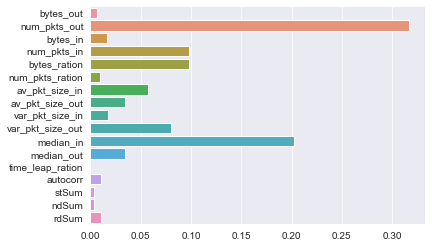

In [15]:
sns.barplot(x=clf.best_estimator_.feature_importances_,y=features_drop)